In [17]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
import hdbscan

# Reset plotting styles to library defaults so visuals follow the default theme
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
sns.reset_defaults()

# For Plotly, use the default template
import plotly.io as pio
pio.templates.default = 'plotly'


In [18]:
# Load an CSV file
file_path = 'https://www.dropbox.com/scl/fi/1jml6i3whezn5dzarkb6a/credit_card_customers.csv?rlkey=o5yjpunceaa9vo51yyudn0qw8&st=6tcl8ivy&dl=1'
data = pd.read_csv(file_path)

data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Data Exploration

In [19]:
#Compute churn rate and retention rate
attrition_counts = data["Attrition_Flag"].value_counts()
attrition_counts

total_customers = len(data)

num_attrited = attrition_counts.get("Attrited Customer", 0)
num_existing = attrition_counts.get("Existing Customer", 0)

churn_rate = num_attrited / total_customers
retention_rate = num_existing / total_customers

print(f"Annual churn rate: {churn_rate:.3%}")
print(f"Annual retention rate: {retention_rate:.3%}")


Annual churn rate: 16.066%
Annual retention rate: 83.934%


In [20]:
# Drop ID and outcome variable for clustering EDA
df_eda = data.drop(columns=["CLIENTNUM", "Attrition_Flag"], errors="ignore")

# Numeric vs categorical
num_cols = df_eda.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in df_eda.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print(num_cols)
print("\nCategorical columns:", len(cat_cols))
print(cat_cols)

#check any missing value
df_eda.isna().any().any()

#statistic
num_cols = df_eda.select_dtypes(include=np.number).columns.tolist()

df_eda[num_cols].describe().T

Numeric columns: 14
['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

Categorical columns: 5
['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


In [21]:
#relationship on card category to their spending behaviour
card_order = ["Blue", "Silver", "Gold", "Platinum"]
key_numeric = [
    "Avg_Utilization_Ratio",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Revolving_Bal",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Ct_Chng_Q4_Q1",
]

key_numeric = [c for c in key_numeric if c in df_eda.columns]

# Convert 'Card_Category' to a Categorical type with the specified order
df_eda['Card_Category'] = pd.Categorical(df_eda['Card_Category'], categories=card_order, ordered=True)

df_eda.groupby("Card_Category")[key_numeric].mean().round(2)

,Avg_Utilization_Ratio,Total_Trans_Amt,Total_Trans_Ct,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1
Card_Category,,,,,,
Blue,0.29,4225.41,64.03,1157.81,0.76,0.71
Silver,0.06,6590.48,74.70,1206.13,0.76,0.71
Gold,0.06,7685.61,81.52,1344.32,0.77,0.71
Platinum,0.04,8999.75,86.95,1267.95,0.78,0.67


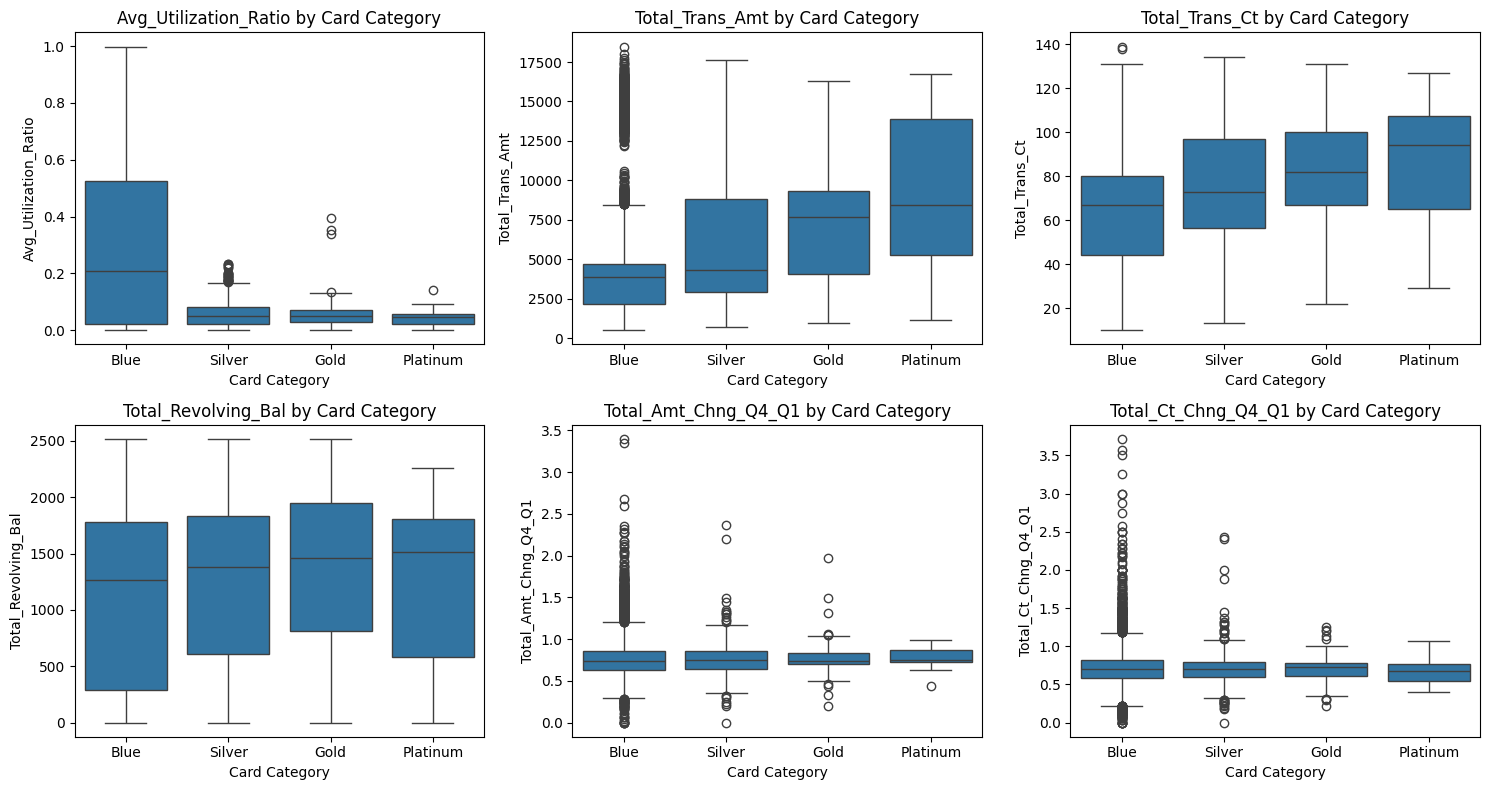

In [22]:
n_cols = 3                      # how many plots per row
n_rows = math.ceil(len(key_numeric) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(key_numeric):
    sns.boxplot(
        x="Card_Category",
        y=col,
        data=df_eda,
        ax=axes[i]
    )
    axes[i].set_title(f"{col} by Card Category")
    axes[i].set_xlabel("Card Category")
    axes[i].set_ylabel(col)

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




This EDA indicates some card category overlapping and outlier

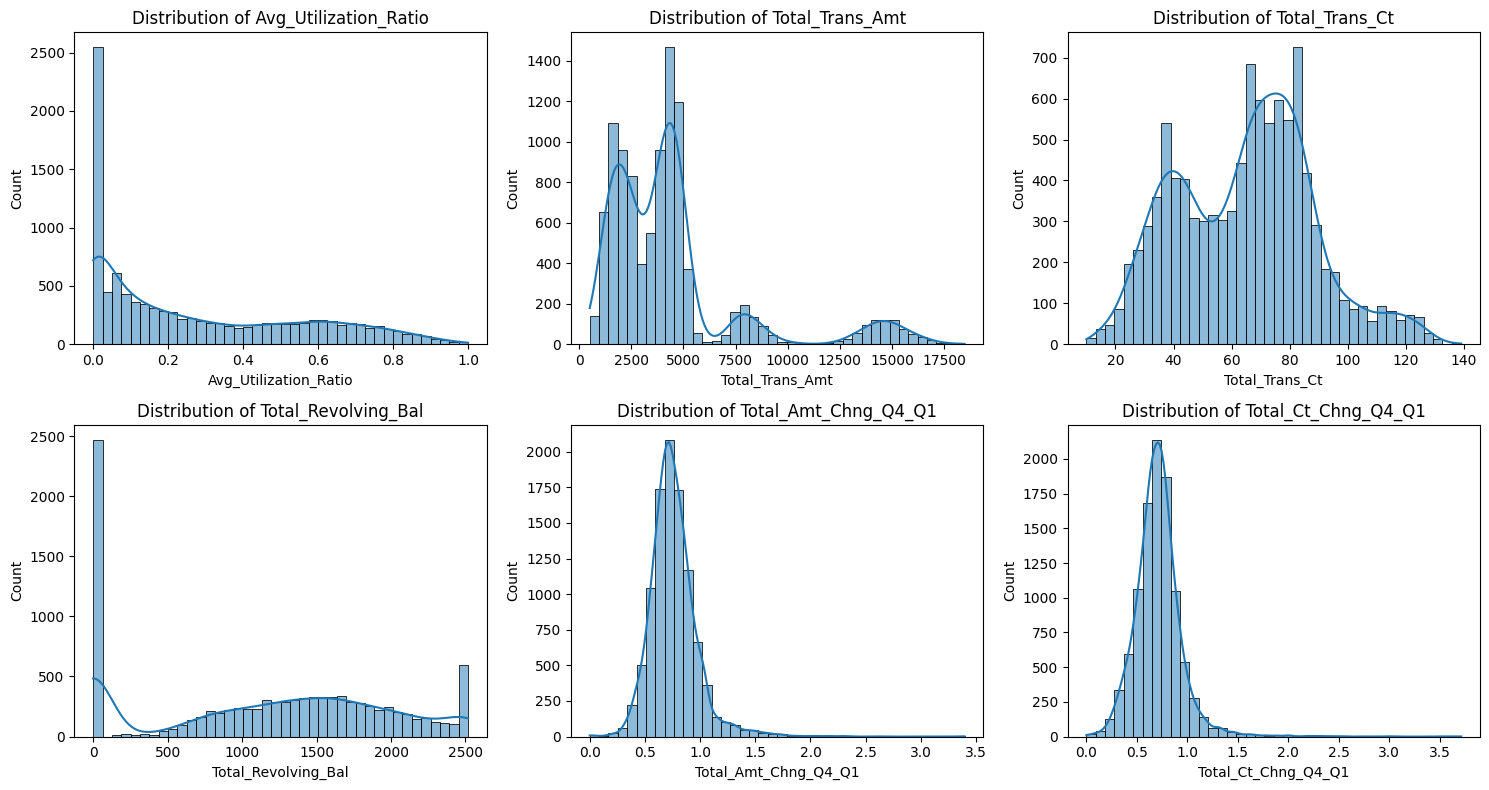

In [23]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(key_numeric):
    sns.histplot(df_eda[col], bins=40, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [24]:
#Analysis based on revenue driver
#Average utilization ratio is left skewed, meaning to increase transaction-based fee,

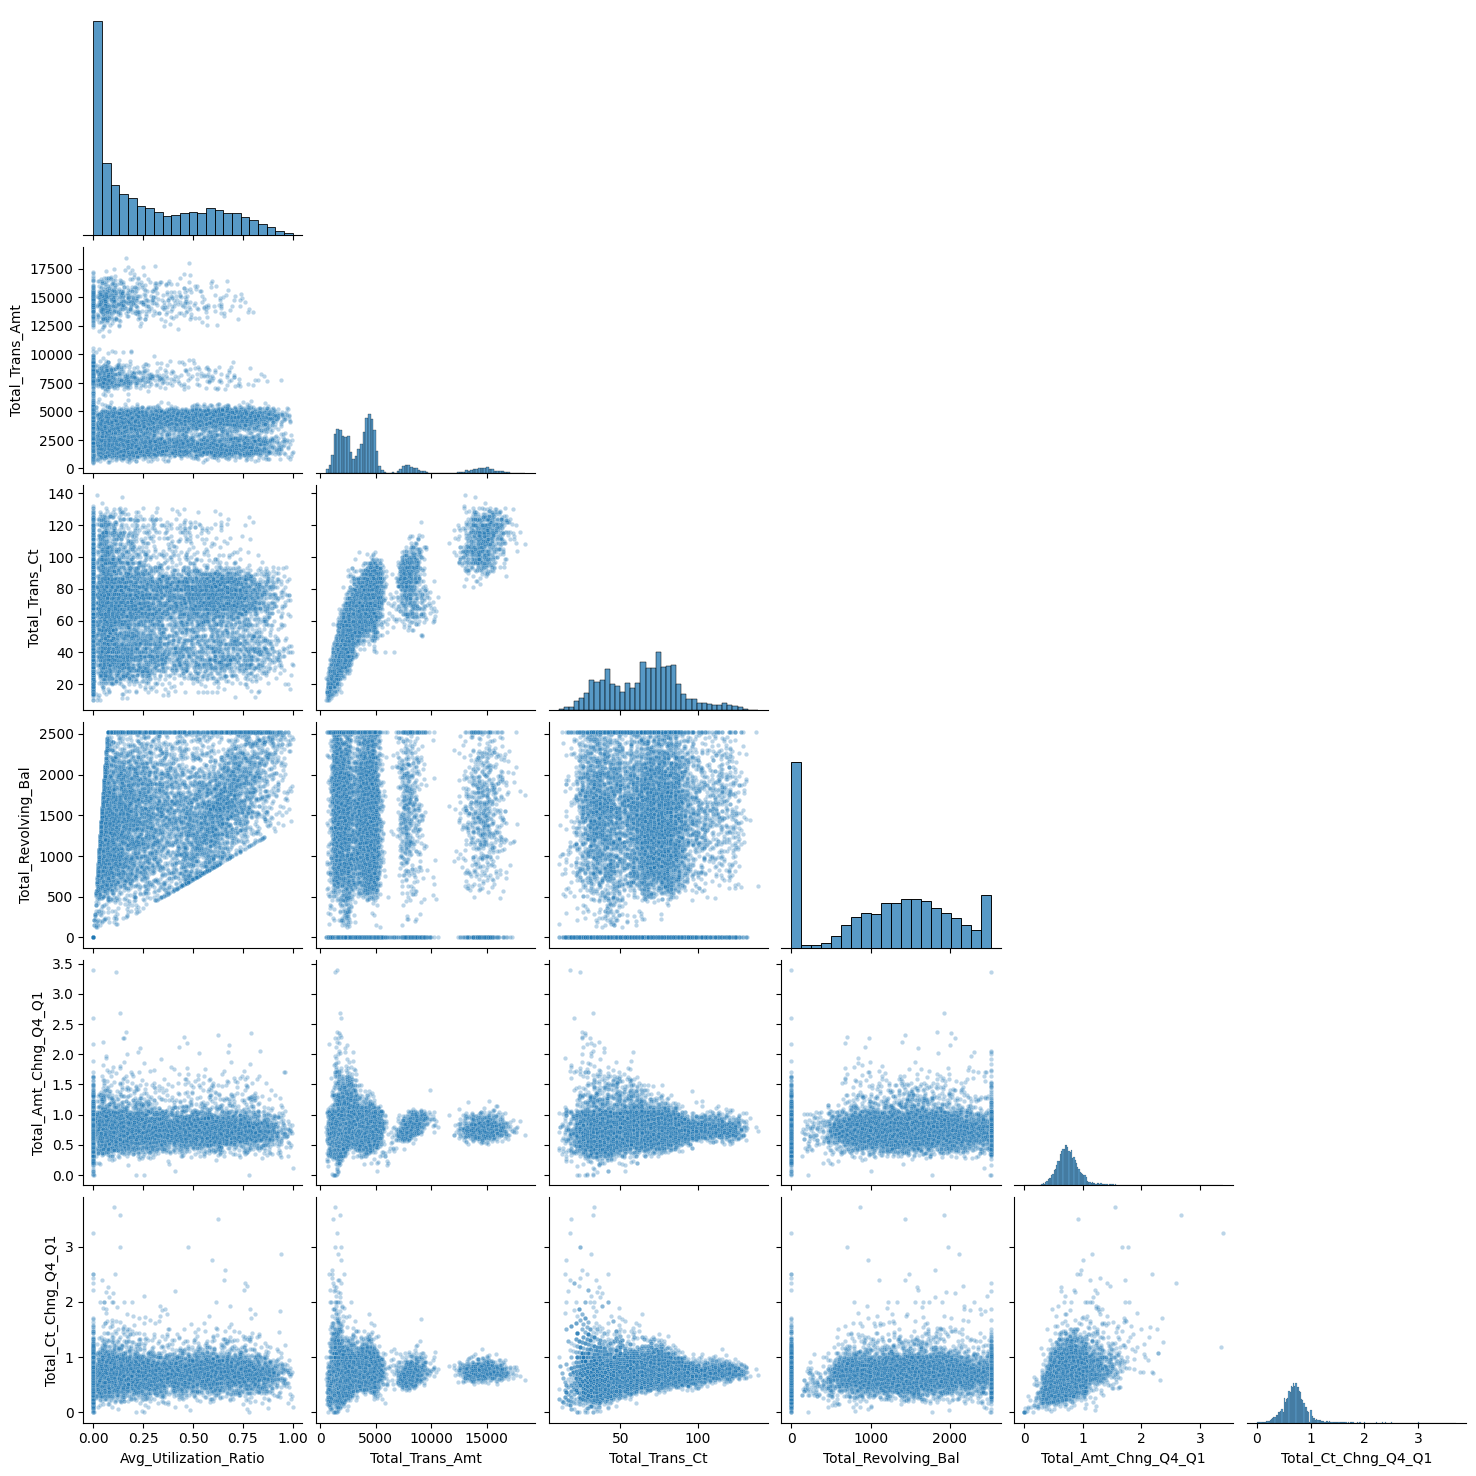

In [25]:
sns.pairplot(
    df_eda[key_numeric],
    corner=True,
    plot_kws={"alpha": 0.3, "s": 10}
)
plt.show()


#Analysis on Behaviour compared to the revenue driver:
1. Credit Utilization Behaviour & Interest Potential
Key feature : avg_utilization ratio & revolving balance
The plots comparing Revolving balance vs Average Utilization Ratio exhibits a clear triangular or wedge-shaped structure rather than a linear trend. Rrevolving balances are bounded by a customer’s credit limit and therefore increase mechanically with utilization. Customers with high utilization ratios are operating close to their credit limits and are more likely to carry persistent balances, generating interest revenue but also indicating elevated financial stress.

2. Spending Behaviour
Key Feature ;
a) Total_trans_amt & Total_trans_ct --> signalling 3 clusters
b) Revolving balance & Total trans_amt --> the figure shows vertical bands and substantial dispersion, indicating that customers with similar transaction volumes can have very different revolving balances. Many customers with high transaction amounts carry little or no revolving balance, while others accumulate substantial balances despite moderate transaction activity.



# A**nalysis on Engagement & Relationship Behaviour**


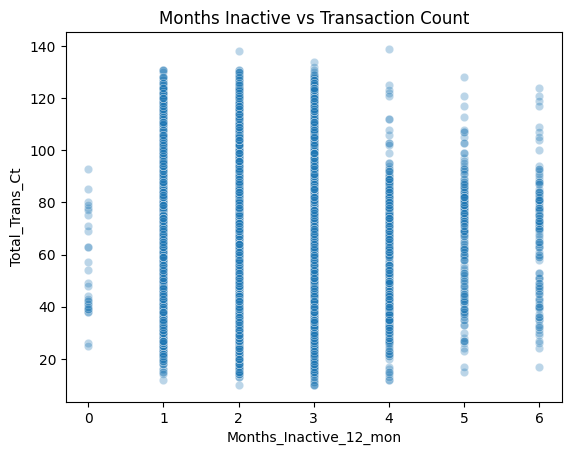

In [26]:
if "Months_Inactive_12_mon" in df_eda.columns:
    plt.figure()
    sns.scatterplot(x=df_eda["Months_Inactive_12_mon"], y=df_eda["Total_Trans_Ct"], alpha=0.3)
    plt.title("Months Inactive vs Transaction Count")
    plt.xlabel("Months_Inactive_12_mon")
    plt.ylabel("Total_Trans_Ct")
    plt.show()


There is a clear negative association
As months inactive increase, the typical transaction count decreases.

“The scatterplot of months inactive versus transaction count shows a clear decline in transaction activity as inactivity increases, with substantial heterogeneity within each inactivity level.

There is also Ratio called: "Contact-to-Inactivity Ratio": Contacts_ct_12_mon/ months_inactive_12_mon.

Variable: Total_Amt_Chng_Q4_Q1", "Total_Ct_Chng_Q4_Q1" also often to test the enggagement level of customer compared the previous term


## Data Preprocesssing I : FOR BEHAVIOUR SEGMENTATION

In [27]:
# ---- Engineer avg transaction value safely ----
# avg_transaction_value = Total_Trans_Amt / Total_Trans_Ct
# Handle Total_Trans_Ct == 0 to avoid division by zero
df=df_eda.copy()
df["avg_transaction_value"] = np.where(
    df["Total_Trans_Ct"] == 0,
    0,
    df["Total_Trans_Amt"] / df["Total_Trans_Ct"]
)

features = [
    "Total_Revolving_Bal",
    "Avg_Utilization_Ratio",
    "avg_transaction_value"
]

X = df[features].copy()

# ---- Basic cleaning ----
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# ---- Scale (critical for K-Means) ----
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

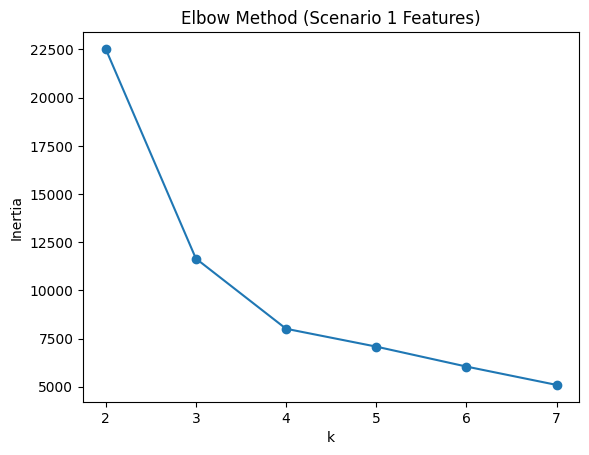

In [28]:
from sklearn.cluster import KMeans

inertias = []
ks = range(2, 8)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(Xs)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(ks, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method (Scenario 1 Features)")
plt.show()


THE Elbow method is still unclear to use the number of k

In [29]:
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init="auto")
labels = kmeans.fit_predict(Xs)

sil = silhouette_score(Xs, labels)
print("Silhouette (full data):", round(sil, 4))


Silhouette (full data): 0.4336


In [30]:
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init="auto")
labels = kmeans.fit_predict(Xs)

sil = silhouette_score(Xs, labels)
print("Silhouette (full data):", round(sil, 4))


Silhouette (full data): 0.4293


In [31]:
def stability_across_seeds(Xs, k=3, seeds=range(40, 60)):
    labels_list = []
    sil_list = []

    for s in seeds:
        km = KMeans(n_clusters=k, random_state=s, n_init="auto")
        labels = km.fit_predict(Xs)
        labels_list.append(labels)
        sil_list.append(silhouette_score(Xs, labels))

    # Pairwise ARI between consecutive runs
    ari_consecutive = [
        adjusted_rand_score(labels_list[i], labels_list[i+1])
        for i in range(len(labels_list)-1)
    ]

    return pd.DataFrame({
        "seed_start": list(seeds)[:-1],
        "seed_next": list(seeds)[1:],
        "ARI_consecutive": ari_consecutive,
        "silhouette_seed_next": sil_list[1:]
    })

seed_stability = stability_across_seeds(Xs, k=k_final)
seed_stability.describe()


,seed_start,seed_next,ARI_consecutive,silhouette_seed_next
count,19.000000,19.000000,19.000000,19.000000
mean,49.000000,50.000000,0.932688,0.428330
std,5.627314,5.627314,0.173722,0.002625
min,40.000000,41.000000,0.437924,0.417533
25%,44.500000,45.500000,0.986901,0.428686
50%,49.000000,50.000000,0.987893,0.428824
75%,53.500000,54.500000,0.993269,0.429139
max,58.000000,59.000000,1.000000,0.429255


===== FULL-DATA SILHOUETTE =====
Baseline silhouette (k=3): 0.4336
With growth vars silhouette (k=3): 0.2815

===== STABILITY SUMMARY (ARI) =====
Baseline ARI_consecutive describe:
count    19.000000
mean      0.983353
std       0.015677
min       0.963856
25%       0.967430
50%       0.994107
75%       0.998255
max       1.000000
Name: ARI_consecutive, dtype: float64

With Growth Vars ARI_consecutive describe:
count    19.000000
mean      0.890388
std       0.207136
min       0.496036
25%       0.983486
50%       0.992766
75%       0.998737
max       1.000000
Name: ARI_consecutive, dtype: float64

===== CLUSTER PROFILES (MEANS + COUNTS) =====

Baseline profile:
         Total_Revolving_Bal  Avg_Utilization_Ratio  avg_transaction_value  \
cluster                                                                      
0                  1729.5931                 0.4896                54.2810   
1                   441.5449                 0.0552                54.2829   
2                

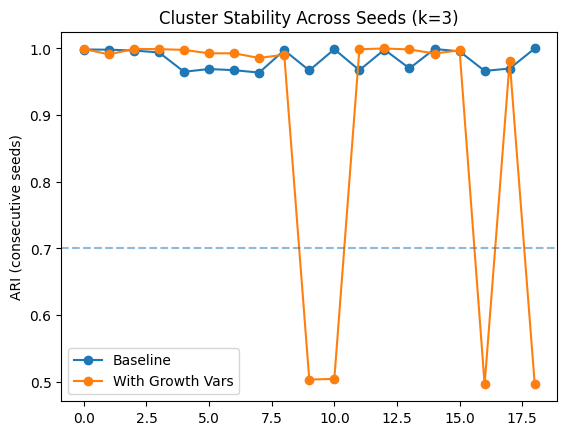

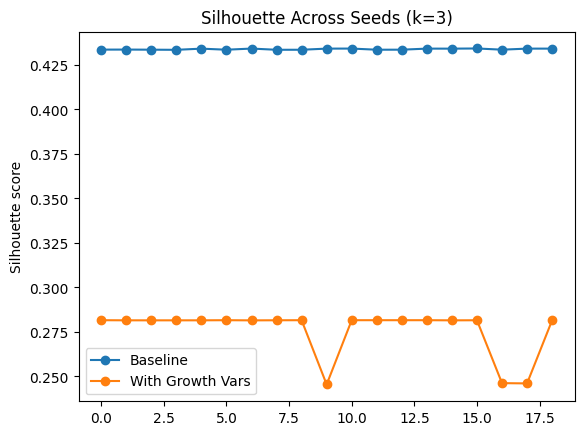

In [32]:
#stability test by adding more variable
# COMPLETE PIPELINE: Engineer features, add growth variables, run K-Means, and test stability (ARI + Silhouette)
# Scenario: Compare stability of:
#   (A) Baseline Scenario 1 features
#   (B) Baseline + "Total_Amt_Chng_Q4_Q1" and "Total_Ct_Chng_Q4_Q1"


# -----------------------------
# 3) Define feature sets
# -----------------------------
features_base = [
    "Total_Revolving_Bal",
    "Avg_Utilization_Ratio",
    "avg_transaction_value"
]

features_growth = [
    "Total_Revolving_Bal",
    "Avg_Utilization_Ratio",
    "avg_transaction_value",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Ct_Chng_Q4_Q1"
]

# -----------------------------
# 4) Helper functions
# -----------------------------
def preprocess_features(df_in, features):
    """
    Select features, clean inf/nan, impute with median, and standardize.
    Returns standardized numpy array Xs.
    """
    X = df_in[features].copy()
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median(numeric_only=True))
    Xs = StandardScaler().fit_transform(X)
    return Xs

def stability_across_seeds(Xs, k=3, seeds=range(40, 60)):
    """
    Fit KMeans repeatedly with different random_state seeds.
    Returns a DataFrame with:
      - ARI between consecutive runs (stability)
      - silhouette scores per run (quality consistency)
    """
    labels_list = []
    sil_list = []

    for s in seeds:
        km = KMeans(n_clusters=k, random_state=s, n_init="auto")
        labels = km.fit_predict(Xs)
        labels_list.append(labels)
        sil_list.append(silhouette_score(Xs, labels))

    ari_consecutive = [
        adjusted_rand_score(labels_list[i], labels_list[i + 1])
        for i in range(len(labels_list) - 1)
    ]

    # align silhouettes to same length as ARI (drop first)
    return pd.DataFrame({
        "seed_start": list(seeds)[:-1],
        "seed_next": list(seeds)[1:],
        "ARI_consecutive": ari_consecutive,
        "silhouette_seed_next": sil_list[1:]
    })

def fit_final_kmeans_and_profile(df_in, Xs, features, k=3, random_state=42):
    """
    Fit final KMeans on full standardized data and return:
      - df_out with cluster labels
      - cluster profile (means + counts)
      - silhouette on full data
    """
    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels = km.fit_predict(Xs)

    df_out = df_in.copy()
    df_out["cluster"] = labels

    profile = df_out.groupby("cluster")[features].mean().round(4)
    profile["count"] = df_out["cluster"].value_counts().sort_index()
    sil = silhouette_score(Xs, labels)

    return df_out, profile, sil

# -----------------------------
# 5) Choose k
# -----------------------------
k_final = 3

# -----------------------------
# 6) Preprocess and test stability (Baseline)
# -----------------------------
Xs_base = preprocess_features(df, features_base)
stability_base = stability_across_seeds(Xs_base, k=k_final, seeds=range(40, 60))

# Fit final model and profile (Baseline)
df_base, profile_base, sil_base = fit_final_kmeans_and_profile(df, Xs_base, features_base, k=k_final)

# -----------------------------
# 7) Preprocess and test stability (With Growth Variables)
# -----------------------------
Xs_growth = preprocess_features(df, features_growth)
stability_growth = stability_across_seeds(Xs_growth, k=k_final, seeds=range(40, 60))

# Fit final model and profile (With Growth Variables)
df_growth, profile_growth, sil_growth = fit_final_kmeans_and_profile(df, Xs_growth, features_growth, k=k_final)

# -----------------------------
# 8) Print summary results
# -----------------------------
print("===== FULL-DATA SILHOUETTE =====")
print(f"Baseline silhouette (k={k_final}): {sil_base:.4f}")
print(f"With growth vars silhouette (k={k_final}): {sil_growth:.4f}")

print("\n===== STABILITY SUMMARY (ARI) =====")
print("Baseline ARI_consecutive describe:")
print(stability_base["ARI_consecutive"].describe())

print("\nWith Growth Vars ARI_consecutive describe:")
print(stability_growth["ARI_consecutive"].describe())

print("\n===== CLUSTER PROFILES (MEANS + COUNTS) =====")
print("\nBaseline profile:")
print(profile_base)

print("\nWith Growth Vars profile:")
print(profile_growth)

# -----------------------------
# 9) Visualize stability (ARI + Silhouette over seed runs)
# -----------------------------
plt.figure()
plt.plot(stability_base["ARI_consecutive"].values, marker="o", label="Baseline")
plt.plot(stability_growth["ARI_consecutive"].values, marker="o", label="With Growth Vars")
plt.axhline(0.7, linestyle="--", alpha=0.5)
plt.ylabel("ARI (consecutive seeds)")
plt.title(f"Cluster Stability Across Seeds (k={k_final})")
plt.legend()
plt.show()

plt.figure()
plt.plot(stability_base["silhouette_seed_next"].values, marker="o", label="Baseline")
plt.plot(stability_growth["silhouette_seed_next"].values, marker="o", label="With Growth Vars")
plt.ylabel("Silhouette score")
plt.title(f"Silhouette Across Seeds (k={k_final})")
plt.legend()
plt.show()


## K-Means Clustering

In [33]:
#prepare fetaures and scaling
features = [
    "Total_Revolving_Bal",
    "Avg_Utilization_Ratio",
    "avg_transaction_value"
]

df_work=df.copy()
# Add Attrition_Flag to df_work so it can be used for filtering
df_work["Attrition_Flag"] = data["Attrition_Flag"]
X = df_work[features].copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

k_final = 3   # change to 4 if you want to test k=4

kmeans = KMeans(n_clusters=k_final, random_state=42, n_init="auto")
df_work["cluster"] = kmeans.fit_predict(Xs)

df_work["cluster"].value_counts().sort_index()

cluster
0    4839
1    4074
2    1214
Name: count, dtype: int64

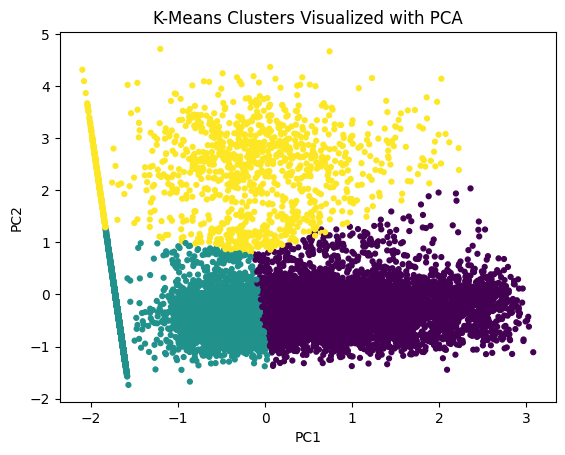

Explained variance ratio (PC1, PC2): [0.54288625 0.33708581]


In [34]:
#pca visualization
pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(Xs)

plt.figure()
plt.scatter(Xp[:, 0], Xp[:, 1], c=df_work["cluster"], s=12)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters Visualized with PCA")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)


In [35]:
cluster_profile = df_work.groupby("cluster")[features].mean().round(3)
cluster_profile["count"] = df_work["cluster"].value_counts().sort_index()
cluster_profile


,Total_Revolving_Bal,Avg_Utilization_Ratio,avg_transaction_value,count
cluster,,,,
0,1729.593,0.490,54.281,4839
1,441.545,0.055,54.283,4074
2,1324.105,0.156,123.777,1214


Card_Category   Blue  Silver   Gold  Platinum
cluster                                      
0              0.976   0.019  0.004     0.000
1              0.926   0.062  0.010     0.002
2              0.775   0.171  0.045     0.009
Card_Category  Blue  Silver  Gold  Platinum
cluster                                    
0              4724      94    21         0
1              3771     254    40         9
2               941     207    55        11


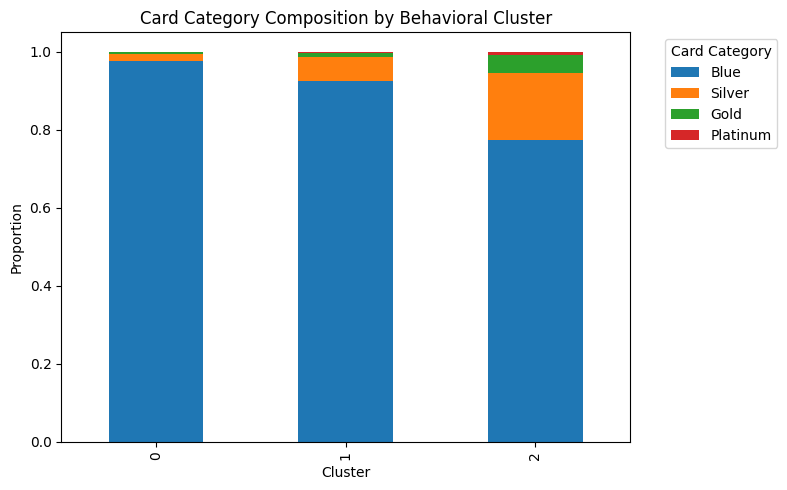

,Total_Revolving_Bal,Avg_Utilization_Ratio,avg_transaction_value,count
cluster,,,,
0,1729.59,0.49,54.28,4839
1,441.54,0.06,54.28,4074
2,1324.10,0.16,123.78,1214


In [36]:
#post-hoc validation: Check the clusters relate to the bank’s existing card categories (Blue, Silver, Gold, Platinum)
cluster_card_pct = pd.crosstab(
    df_work["cluster"],
    df_work["Card_Category"],
    normalize="index"
).round(3)

print(cluster_card_pct)

#cluster counts
cluster_card_counts = pd.crosstab(
    df_work["cluster"],
    df_work["Card_Category"]
)

print(cluster_card_counts)

#visualize
cluster_card_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
)

plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.title("Card Category Composition by Behavioral Cluster")
plt.legend(title="Card Category", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

cluster_profile = (
    df_work
    .groupby("cluster")[features]
    .mean()
    .round(2)
)

cluster_profile["count"] = df_work["cluster"].value_counts().sort_index()
cluster_profile

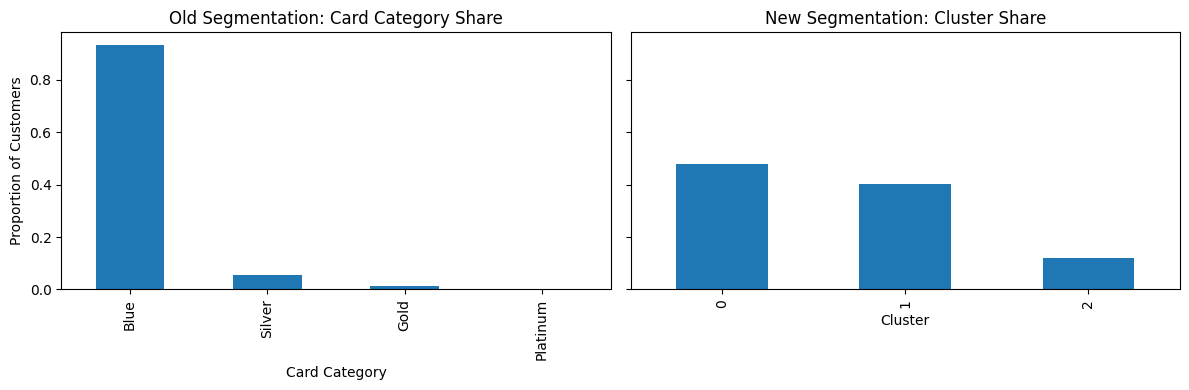

Old (Card Category) distribution:
Card_Category
Blue        0.932
Silver      0.055
Gold        0.011
Platinum    0.002
Name: proportion, dtype: float64

New (Cluster) distribution:
cluster
0    0.478
1    0.402
2    0.120
Name: proportion, dtype: float64


In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Overall distribution by existing card category (proportion of customers)
overall_card_dist = (
    df_work["Card_Category"]
    .value_counts(normalize=True)
    .sort_index()
)

# 2) Distribution by new clusters (proportion of customers)
cluster_dist = (
    df_work["cluster"]
    .value_counts(normalize=True)
    .sort_index()
)

# 3) Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

overall_card_dist.plot(kind="bar", ax=axes[0])
axes[0].set_title("Old Segmentation: Card Category Share")
axes[0].set_xlabel("Card Category")
axes[0].set_ylabel("Proportion of Customers")
axes[0].set_ylim(0, max(overall_card_dist.max(), cluster_dist.max()) + 0.05)

cluster_dist.plot(kind="bar", ax=axes[1])
axes[1].set_title("New Segmentation: Cluster Share")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Proportion of Customers")

plt.tight_layout()
plt.show()

# Optional: print the exact proportions
print("Old (Card Category) distribution:")
print(overall_card_dist.round(3))

print("\nNew (Cluster) distribution:")
print(cluster_dist.round(3))


Business Takeways:
1. Almost half of customers from Blue Card can be offered to card ugrade to increase the revenue from transaction fee or amount fee percentage.
2. There are 7% of existing customers that can be added to the top-tier card (Gold or Platinum).

## Data Preprocesssing II : FOR ENGAGEMENT SEGMENTATION
Attrition customers is a revenue-loss for credit card company. This segmentation want to look for signal for hugh-risk potential attrited customers.

In [38]:
df_feat = df_work.copy()

# Ensure 'Attrition_Flag' is in df_feat, copying from original 'data' if needed
# This addresses potential state inconsistencies if df_work did not fully propagate it or if df_feat was reset
if "Attrition_Flag" not in df_feat.columns:
    df_feat["Attrition_Flag"] = data["Attrition_Flag"]

# 1. Contact–Inactivity Ratio (safe for zero inactivity)
df_feat["contact_inactivity_ratio"] = (
    df_feat["Contacts_Count_12_mon"] /
    (df_feat["Months_Inactive_12_mon"] + 1)
)

# 2. Select final engagement features
engagement_features = [
    "contact_inactivity_ratio",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio"
]

X = df_feat[engagement_features].copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# 3. Scaling
Xs = StandardScaler().fit_transform(X)

#$.silhoutee
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = {}

for k in range(2, 7):
    labels = KMeans(n_clusters=k, random_state=42, n_init="auto").fit_predict(Xs)
    silhouette_scores[k] = silhouette_score(Xs, labels)

print(silhouette_scores)
k_final = max(silhouette_scores, key=silhouette_scores.get)
print("Best k:", k_final)

#6.m Fit final k-means
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init="auto")
df_feat["cluster_kmeans"] = kmeans.fit_predict(Xs)
print(df_feat["cluster_kmeans"].value_counts())

{2: 0.25950380130403555, 3: 0.2547627983140061, 4: 0.2302327028322705, 5: 0.22793883825802996, 6: 0.21519081826894115}
Best k: 2
cluster_kmeans
1    6458
0    3669
Name: count, dtype: int64


In [39]:
#DBSCAN CLUSTERING
#Run DBSCAN (density-based)
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.9, min_samples=25)
df_feat["cluster_dbscan"] = dbscan.fit_predict(Xs)
print(df_feat["cluster_dbscan"].value_counts())

cluster_dbscan
 0    9695
-1     432
Name: count, dtype: int64


In [40]:
#STABILITY FOR K-MEANS

def cluster_stability(model_fn, X, n_iter=10, sample_frac=0.8):
    scores = []
    n = X.shape[0]

    for _ in range(n_iter):
        idx = np.random.choice(n, int(sample_frac*n), replace=False)
        X_sub = X[idx]

        labels1 = model_fn(X_sub)
        labels2 = model_fn(X_sub)

        scores.append(adjusted_rand_score(labels1, labels2))

    return np.mean(scores)
kmeans_stability = cluster_stability(
    lambda Z: KMeans(n_clusters=k_final, random_state=42, n_init="auto").fit_predict(Z),
    Xs
)
print(f"k-means stability is {kmeans_stability}")

#stability for db-scan
from sklearn.metrics import adjusted_rand_score
import numpy as np

def dbscan_stability_correct(X, eps=0.9, min_samples=25, n_iter=10, sample_frac=0.8):
    scores = []
    n = X.shape[0]

    for _ in range(n_iter):
        idx1 = np.random.choice(n, int(sample_frac*n), replace=False)
        idx2 = np.random.choice(n, int(sample_frac*n), replace=False)

        labels1 = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X[idx1])
        labels2 = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X[idx2])

        # Only compare points that appear in both subsamples
        common = np.intersect1d(idx1, idx2)

        if len(common) > 10:
            l1 = labels1[np.isin(idx1, common)]
            l2 = labels2[np.isin(idx2, common)]
            scores.append(adjusted_rand_score(l1, l2))

    return np.mean(scores)
dbscan_stability = dbscan_stability_correct(Xs)
dbscan_stability
print(f"DBSCAN stability is {dbscan_stability}")

#

k-means stability is 1.0
DBSCAN stability is 0.004485146467554888


For the purpose of detecting high-potential churn customers, DBSCAN is better because it more sensitives to noise or flag extremes and cluster the customers that may corresponds as potential churn customers

## Hierarchical Clustering

## DBSCAN

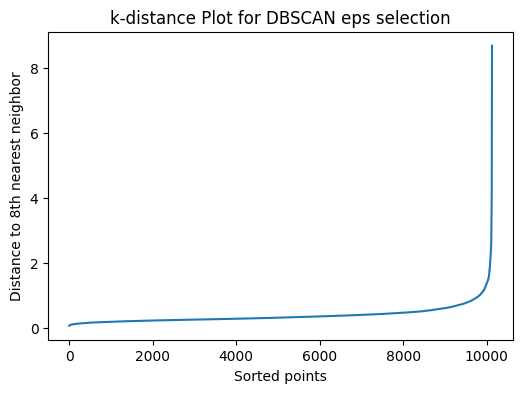

cluster_dbscan
 0    9894
-1     221
 1      12
Name: count, dtype: int64
If -1 = noise -> extreme disengagement -> high churn risk
Other integers = dense engagement clusters -> low churn risk


In [42]:
from sklearn.neighbors import NearestNeighbors

# Final DBSCAN feature set (engagement + risk)
dbscan_features = [
    "contact_inactivity_ratio",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio"
]

X = df_feat[dbscan_features].copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

#scale features
Xs = StandardScaler().fit_transform(X)

#choose eps for k-distance
# Rule of thumb: min_samples ≈ 2 × number of features
min_samples = 8

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(Xs)
distances, indices = neighbors_fit.kneighbors(Xs)

# Sort distances to the kth neighbor
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel("Sorted points")
plt.ylabel(f"Distance to {min_samples}th nearest neighbor")
plt.title("k-distance Plot for DBSCAN eps selection")
plt.show()

#run dbscan
eps_value = 0.9   # adjust based on k-distance plot

dbscan = DBSCAN(
    eps=eps_value,
    min_samples=min_samples
)

df_feat["cluster_dbscan"] = dbscan.fit_predict(Xs)

#inspect dbscan output
df_feat["cluster_dbscan"].value_counts()
print(df_feat["cluster_dbscan"].value_counts())

print("If -1 = noise -> extreme disengagement -> high churn risk")
print("Other integers = dense engagement clusters -> low churn risk")
#
#

In [43]:
#post-hoc analysis to the existing attrition flag
df_feat["churn"] = (data["Attrition_Flag"] == "Attrited Customer").astype(int)

churn_by_cluster = (
    df_feat.groupby("cluster_dbscan")["churn"]
    .mean()
    .round(3)
)

churn_by_cluster


cluster_dbscan
-1    0.145
 0    0.161
 1    0.083
Name: churn, dtype: float64

In [45]:
# Post-hoc analysis (DBSCAN): Flag potential churn ONLY for noise label (-1)
# Goal: Potential churn customers = Existing Customer AND cluster_dbscan == -1
# This avoids the "95% at risk" artifact from selecting the dominant DBSCAN cluster.

import numpy as np
import pandas as pd

# --- STEP 1: Compute churn rate by DBSCAN cluster (including -1 noise) ---
df_tmp = data.copy()
df_tmp["cluster_dbscan"] = df_feat["cluster_dbscan"].values  # ensure alignment
df_tmp["is_attrited"] = (df_tmp["Attrition_Flag"] == "Attrited Customer")

cluster_churn_rate = df_tmp.groupby("cluster_dbscan")["is_attrited"].mean()
print("Churn rate by DBSCAN cluster:\n", cluster_churn_rate)

# Overall churn (for reference)
overall_churn_rate = df_tmp["is_attrited"].mean()
print("\nOverall churn rate:", round(overall_churn_rate, 4))

# --- STEP 2: Define potential churn ONLY as DBSCAN noise points (-1) among existing customers ---
potential_churn_customers = df_tmp[
    (df_tmp["Attrition_Flag"] == "Existing Customer") &
    (df_tmp["cluster_dbscan"] == -1)
].copy()

num_potential_churn = len(potential_churn_customers)
num_existing = (df_tmp["Attrition_Flag"] == "Existing Customer").sum()
potential_churn_rate = num_potential_churn / num_existing if num_existing else np.nan

print("\nPotential churn customers (Existing AND cluster_dbscan == -1):", num_potential_churn)
print(f"Share of existing customers at risk (noise only): {potential_churn_rate:.2%}")

# --- (Optional) sanity check: compare churn within noise vs non-noise ---
noise_churn = df_tmp[df_tmp["cluster_dbscan"] == -1]["is_attrited"].mean()
nonnoise_churn = df_tmp[df_tmp["cluster_dbscan"] != -1]["is_attrited"].mean()
print("\nChurn rate among noise (-1):", round(noise_churn, 4))
print("Churn rate among non-noise:", round(nonnoise_churn, 4))

# --- (Optional) view a few flagged customers (if CLIENTNUM exists) ---
cols_to_show = [c for c in ["CLIENTNUM", "Card_Category", "Total_Trans_Ct", "Total_Trans_Amt",
                           "Total_Revolving_Bal", "Avg_Utilization_Ratio", "cluster_dbscan", "Attrition_Flag"]
                if c in df_tmp.columns]

print("\nSample of potential churn customers (noise only):")
print(potential_churn_customers[cols_to_show].head(10))


Churn rate by DBSCAN cluster:
 cluster_dbscan
-1    0.144796
 0    0.161108
 1    0.083333
Name: is_attrited, dtype: float64

Overall churn rate: 0.1607

Potential churn customers (Existing AND cluster_dbscan == -1): 189
Share of existing customers at risk (noise only): 2.22%

Churn rate among noise (-1): 0.1448
Churn rate among non-noise: 0.161

Sample of potential churn customers (noise only):
    CLIENTNUM Card_Category  Total_Trans_Ct  Total_Trans_Amt  \
0   768805383          Blue              42             1144   
1   818770008          Blue              33             1291   
2   713982108          Blue              20             1887   
3   769911858          Blue              20             1171   
4   709106358          Blue              28              816   
6   810347208          Gold              31             1330   
7   818906208        Silver              36             1538   
8   710930508          Blue              24             1350   
12  710599683          Bl

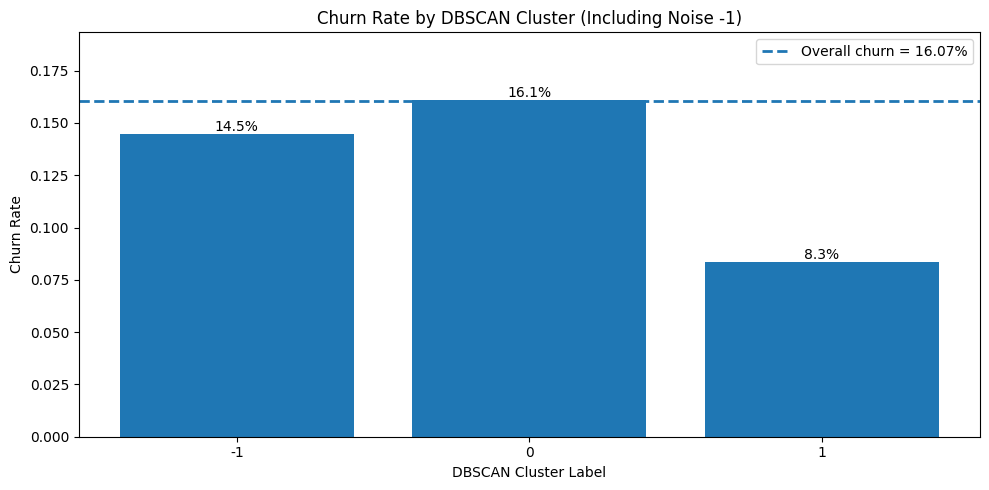

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make sure df_tmp and cluster_churn_rate exist from your code
# cluster_churn_rate = df_tmp.groupby("cluster_dbscan")["is_attrited"].mean()
# overall_churn_rate = df_tmp["is_attrited"].mean()

# Sort clusters nicely: put -1 first, then 0,1,2,...
idx = list(cluster_churn_rate.index)
idx_sorted = sorted([i for i in idx if i != -1])
if -1 in idx:
    idx_sorted = [-1] + idx_sorted

rates = cluster_churn_rate.loc[idx_sorted]

plt.figure(figsize=(10, 5))
plt.bar([str(i) for i in rates.index], rates.values)
plt.axhline(overall_churn_rate, linewidth=2, linestyle="--", label=f"Overall churn = {overall_churn_rate:.2%}")
plt.title("Churn Rate by DBSCAN Cluster (Including Noise -1)")
plt.xlabel("DBSCAN Cluster Label")
plt.ylabel("Churn Rate")
plt.ylim(0, max(rates.max(), overall_churn_rate) * 1.2 if max(rates.max(), overall_churn_rate) > 0 else 1)

# annotate values
for x, y in enumerate(rates.values):
    plt.text(x, y, f"{y:.1%}", ha="center", va="bottom")

plt.legend()
plt.tight_layout()
plt.show()


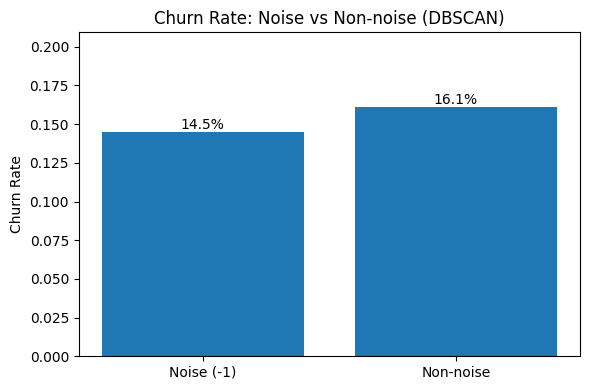

In [49]:
noise_churn = df_tmp[df_tmp["cluster_dbscan"] == -1]["is_attrited"].mean()
nonnoise_churn = df_tmp[df_tmp["cluster_dbscan"] != -1]["is_attrited"].mean()

plt.figure(figsize=(6, 4))
labels = ["Noise (-1)", "Non-noise"]
values = [noise_churn, nonnoise_churn]

plt.bar(labels, values)
plt.title("Churn Rate: Noise vs Non-noise (DBSCAN)")
plt.ylabel("Churn Rate")
plt.ylim(0, max(values) * 1.3 if max(values) > 0 else 1)

for i, v in enumerate(values):
    plt.text(i, v, f"{v:.1%}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


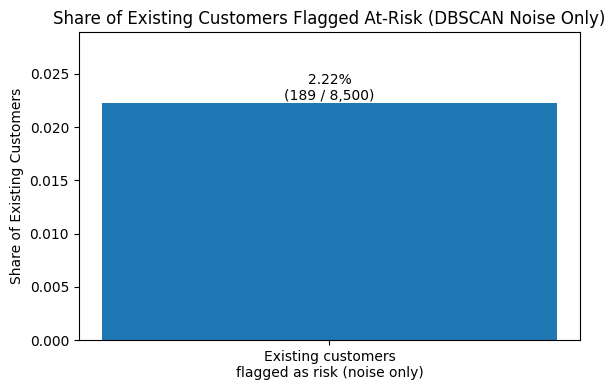

In [50]:
num_potential_churn = ((df_tmp["Attrition_Flag"] == "Existing Customer") & (df_tmp["cluster_dbscan"] == -1)).sum()
num_existing = (df_tmp["Attrition_Flag"] == "Existing Customer").sum()
potential_churn_rate = num_potential_churn / num_existing if num_existing else np.nan

plt.figure(figsize=(6, 4))
plt.bar(["Existing customers\nflagged as risk (noise only)"], [potential_churn_rate])
plt.title("Share of Existing Customers Flagged At-Risk (DBSCAN Noise Only)")
plt.ylabel("Share of Existing Customers")
plt.ylim(0, min(1, potential_churn_rate * 1.3) if potential_churn_rate == potential_churn_rate else 1)

plt.text(0, potential_churn_rate, f"{potential_churn_rate:.2%}\n({num_potential_churn:,} / {num_existing:,})",
         ha="center", va="bottom")

plt.tight_layout()
plt.show()


Business tAKEAWAYS: provide better offers or deals for high-potential churn customers to make the customers loyal.